# MRP : Implementing Pre-retrival Methods

In [1]:
#Importing Libraries 
import numpy as np
import os
from random import shuffle
import re
import urllib.request
import zipfile
import lxml.etree
#import wordcloud
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import math
import numpy
import string
from  nltk.tokenize  import word_tokenize
import datetime

### Reading TREC's ROBUST data collection 

In [2]:
# Set the Root file path - Path need to be changed
RootFilePath="C:/NareshPersonal/Python/MRP/rb04/"

#1.Loading all the collection documents 
#'test' is collections document folder name (might need to be changed) inside RootFilePath 
data_folder = os.path.join(RootFilePath, 'rb04')  

#2.Loading all the Queries 
df2=pd.read_csv(RootFilePath+"rb04-queries.txt",delimiter=":",names=['QueryNo','Query'])

#3.Loading MAP results for comparision later 
dfmap=pd.read_csv(RootFilePath+"qmaporder.txt",delimiter=' ',names=['QueryNo','MAP'])

### Prep Work for intermediate Calculation and document collection statistics

In [4]:
print("Start Time: ", datetime.datetime.now())
all_recipe_files = [os.path.join(data_folder, fname)
                    for fname in os.listdir(data_folder)]
documents = {}
doc_tokens_lower2={}
for recipe_fname in all_recipe_files:
    bname = os.path.basename(recipe_fname)
    recipe_number = os.path.splitext(bname)[0]
    with open(recipe_fname, 'r') as f:
        documents[recipe_number] = f.read()
        doc_tokens = [t for t in word_tokenize(documents[recipe_number].lower())]
        doc_tokens_lower2[recipe_number] = [t.lower() for t in doc_tokens if t not in string.punctuation]
        
#Getting entire Corpus        
corpus_all_in_one = ' '.join([doc for doc in documents.values()])

#Printing Number of Docs, total Tokens and total Characters
print("Number of docs: {}".format(len(documents)))

try:  # py3
    all_tokens = [t for t in word_tokenize(corpus_all_in_one)]
except UnicodeDecodeError: 
    all_tokens = [t for t in word_tokenize(corpus_all_in_one.decode('utf-8'))]

print("Total number of tokens: {}".format(len(all_tokens)))

#print("Corpus size (char): {}".format(len(corpus_all_in_one)))

all_recipe_files_name = [fname for fname in os.listdir(data_folder)]

#Generating term frequency for entire collection for the purpose of calculating tf(t,D)
#from nltk.stem import PorterStemmer
#from  collections  import Counter
#stemmer = PorterStemmer()
all_tokens_lower = [t.lower() for t in all_tokens
                   if t not in string.punctuation]
#total_term_frequency_normalised = Counter(all_tokens_lower)

print("Total number of tokens lower & no punct: {}".format(len(all_tokens_lower)))
print("End Time: ", datetime.datetime.now())

Start Time:  2018-07-22 16:52:34.438368
Number of docs: 31314
Total number of tokens: 34887440
Total number of tokens lower & no punct: 28564676
End Time:  2018-07-22 17:00:57.055368


In [ ]:
#for fname in all_recipe_files_name:
#    doc_tokens = [t for t in word_tokenize(documents[fname].lower())]
#    doc_tokens_lower2[fname] = [t.lower() for t in doc_tokens if t not in string.punctuation]

In [5]:
print("Start Time: ", datetime.datetime.now())
query_terms_doc_count={}
query_terms_total_count={}
for i in range(0,df2.index.size):
    for t in [t.lower() for t in word_tokenize(df2['Query'].iloc[i])if t not in string.punctuation]:
        query_terms_doc_count[t]=0
        query_terms_total_count[t]=0
print("End Time: ", datetime.datetime.now())

Start Time:  2018-07-22 17:01:14.773368
End Time:  2018-07-22 17:01:14.905368


In [6]:
print("Start Time: ", datetime.datetime.now())
for k,v in doc_tokens_lower2.items():
    for t in v:
        if t in query_terms_total_count.keys():
            query_terms_total_count[t]=query_terms_total_count[t]+1
    for t2 in query_terms_doc_count:
        if t2 in v:
            query_terms_doc_count[t2]=query_terms_doc_count[t2]+1
print("End Time: ", datetime.datetime.now())

Start Time:  2018-07-22 17:01:19.851368
End Time:  2018-07-22 17:03:39.137368


### Main code for the calculation of avgIDF, SCS(Q), maxSCQ, sumSCQ and avgSCQ metrics for each query

In [7]:
#Calculating avgIDF, SCS(Q), maxSCQ, maxVAR metrics for each query
print("Start Time: ", datetime.datetime.now())
davgidf={}
dscsq={}
dmaxscqt={}
dsumscqt={}
davgscqt={}
for i in range(0,df2.index.size):
    query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i])
                   if t not in string.punctuation]
    avgidf=0
    scsq=0
    maxscqt=0
    sumscqt=0
    avgscqt=0
    scqt=0
    for token in query_tokens:
        if query_terms_doc_count[token]>0:
            idft=math.log((len(documents)/query_terms_doc_count[token]),2) #Calculating idf(t) using log base 2
            avgidf=avgidf+idft
            scsq=scsq+math.log((len(all_tokens_lower)/query_terms_total_count[token]),2)
            scqt=(1+math.log(query_terms_total_count[token],2))*idft
            sumscqt=sumscqt+scqt
            if scqt>maxscqt:
                maxscqt=scqt
    davgidf[df2['QueryNo'].iloc[i]]=avgidf/len(query_tokens)
    dscsq[df2['QueryNo'].iloc[i]]=math.log((1/len(query_tokens)),2)+scsq/len(query_tokens)
    dmaxscqt[df2['QueryNo'].iloc[i]]=maxscqt
    dsumscqt[df2['QueryNo'].iloc[i]]=sumscqt
    davgscqt[df2['QueryNo'].iloc[i]]=sumscqt/len(query_tokens)
print("End Time: ", datetime.datetime.now())

Start Time:  2018-07-22 17:16:51.519368
End Time:  2018-07-22 17:16:51.839368


### Code for calculating avgVAR and maxVAR

In [8]:
print("Start Time: ", datetime.datetime.now())
from  collections  import Counter
doc_term_frequency_normalised2 = {}
for fname in all_recipe_files_name:
    doc_term_frequency_normalised2[fname] = Counter(doc_tokens_lower2[fname])
print("End Time: ", datetime.datetime.now())

Start Time:  2018-07-22 17:16:59.096368
End Time:  2018-07-22 17:17:19.086368


In [9]:
#Calculating weights for each term w(t,d) --Approx Run time 10 min.
print("Start Time: ", datetime.datetime.now())
wtd={}
for k, v in doc_term_frequency_normalised2.items():
    for i in range(0,df2.index.size):
        query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i])
                   if t not in string.punctuation]
        for token in query_tokens:
            if v.get(token)!=None:
                wtd[k+"/"+token]=(math.log2(1+v.get(token))*math.log((len(documents)/query_terms_doc_count[token]),2))/len(doc_tokens_lower2[k])
print("End Time: ", datetime.datetime.now())           

Start Time:  2018-07-22 17:17:25.282368
End Time:  2018-07-22 17:27:32.125160


In [10]:
#main code to calculate maxVAR and avgVAR
print("Start Time: ", datetime.datetime.now())
dmaxvar={}
davgvar={}
for i in range(0,df2.index.size):
    query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i]) if t not in string.punctuation]
    maxvar=0
    sumvar=0
    for token in query_tokens:
        dvar={}
        for key in wtd:
            if re.fullmatch('.*'+'/'+token, key):
                dvar[str(df2['QueryNo'].iloc[i])+'/'+key]=wtd[key]
        #print(dvar)
        if len(dvar)>0:
            sumvar=sumvar+np.var(np.array(list(dvar.values())))
            if np.var(np.array(list(dvar.values())))>maxvar:
                maxvar=np.var(np.array(list(dvar.values())))
    dmaxvar[df2['QueryNo'].iloc[i]]=maxvar
    davgvar[df2['QueryNo'].iloc[i]]=sumvar/len(query_tokens)
print("End Time: ", datetime.datetime.now())                

Start Time:  2018-07-22 17:27:52.595207
End Time:  2018-07-22 17:32:39.744919


### Code for calculating avgPMI and maxPMI

In [11]:
query_terms_doc_count_t1t2={}
for i in range(0,df2.index.size):
    query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i]) if t not in string.punctuation]
    for j in range(0,len(query_tokens)):
        for k in range(j+1,len(query_tokens)):
            query_terms_doc_count_t1t2[query_tokens[j],query_tokens[k]]=0                   

In [12]:
print("Start Time: ", datetime.datetime.now())
for k,v in doc_tokens_lower2.items():
    for k1,k2 in query_terms_doc_count_t1t2.keys():
        if k1 in v and k2 in v:
            query_terms_doc_count_t1t2[k1,k2]=query_terms_doc_count_t1t2[k1,k2]+1
print("End Time: ", datetime.datetime.now())

Start Time:  2018-07-22 17:32:43.999344
End Time:  2018-07-22 17:35:16.088552


In [13]:
## Main Code to calculate TERM RELATEDNESS metrics i.e. avgPMI and maxPMI, 
print("Start Time: ", datetime.datetime.now())
davgpmi = {}
dmaxpmi = {}
#Program to Calculate PMI(t1,t2)
D=len(documents) #Total number documents |D|
#D=len(all_tokens_lower) #Total number of terms in entire document colleciton after removing punctuation etc.

for i in range(0,df2.index.size):
    query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i]) if t not in string.punctuation]
    #print(query_tokens)
    n=0
    avgpmi=0
    maxpmi=0
    for j in range(0,len(query_tokens)):
        if len(query_tokens)==1:
            avgpmi=math.log2(1)
            n=1        
        else:
            for k in range(j+1,len(query_tokens)):
                n=n+1
                if query_terms_doc_count_t1t2[query_tokens[j],query_tokens[k]] !=0:
                    pmi=(query_terms_doc_count_t1t2[query_tokens[j],query_tokens[k]]*D)/(query_terms_doc_count[query_tokens[j]]*query_terms_doc_count[query_tokens[k]])
                if pmi!=0:
                    avgpmi=avgpmi+math.log2(pmi)
                    if math.log2(pmi)>maxpmi:
                        maxpmi=math.log2(pmi)
    davgpmi[df2['QueryNo'].iloc[i]]=avgpmi/n
    dmaxpmi[df2['QueryNo'].iloc[i]]=maxpmi
print("End Time: ", datetime.datetime.now())

Start Time:  2018-07-22 17:36:04.226365
End Time:  2018-07-22 17:36:04.278370


In [14]:
df2.insert(len(df2.columns),'avgidf',99)
df2['avgidf']=df2['QueryNo'].map(davgidf)
df2.insert(len(df2.columns),'scsq',99)
df2['scsq']=df2['QueryNo'].map(dscsq)
df2.insert(len(df2.columns),'maxscqt',99)
df2['maxscqt']=df2['QueryNo'].map(dmaxscqt)
df2.insert(len(df2.columns),'sumscqt',99)
df2['sumscqt']=df2['QueryNo'].map(dsumscqt)
df2.insert(len(df2.columns),'avgscqt',99)
df2['avgscqt']=df2['QueryNo'].map(davgscqt)
df2.insert(len(df2.columns),'maxvar',99)
df2['maxvar']=df2['QueryNo'].map(dmaxvar)
df2.insert(len(df2.columns),'avgvar',99)
df2['avgvar']=df2['QueryNo'].map(davgvar)
df2.insert(len(df2.columns),'avgpmi',99)
df2['avgpmi']=df2['QueryNo'].map(davgpmi)
df2.insert(len(df2.columns),'maxpmi',99)
df2['maxpmi']=df2['QueryNo'].map(dmaxpmi)

In [15]:
df3=pd.merge(df2,dfmap,on='QueryNo')
df3.head()

,QueryNo,Query,avgidf,scsq,maxscqt,sumscqt,avgscqt,maxvar,avgvar,avgpmi,maxpmi,MAP
0,301,International Organized Crime,3.865480,11.012275,58.712459,148.612201,49.537400,0.000095,0.000068,1.257175,2.597584,0.0407
1,302,Poliomyelitis and Post-Polio,7.789520,14.367864,60.987195,104.422481,34.807494,0.000684,0.000245,0.023081,0.023081,0.5243
2,303,Hubble Telescope Achievements,7.291412,14.377756,76.548731,212.331965,70.777322,0.004141,0.002545,3.345009,7.779006,0.3654
3,304,Endangered Species (Mammals),5.753165,12.468759,71.097211,199.034946,66.344982,0.000171,0.000114,4.416756,4.502160,0.0443
4,305,Most Dangerous Vehicles,3.462426,10.655563,59.377358,133.835045,44.611682,0.000074,0.000044,0.757663,1.322016,0.0009


           avgidf      scsq   avgscqt   maxscqt   sumscqt    avgvar    maxvar  \
avgidf   1.000000  0.949072  0.489866  0.134825 -0.073012  0.403734  0.317406   
scsq     0.949072  1.000000  0.533564  0.034479 -0.156463  0.366829  0.268384   
avgscqt  0.489866  0.533564  1.000000  0.551896  0.322898  0.371758  0.278420   
maxscqt  0.134825  0.034479  0.551896  1.000000  0.392484  0.279730  0.290152   
sumscqt -0.073012 -0.156463  0.322898  0.392484  1.000000 -0.076149  0.014755   
avgvar   0.403734  0.366829  0.371758  0.279730 -0.076149  1.000000  0.947240   
maxvar   0.317406  0.268384  0.278420  0.290152  0.014755  0.947240  1.000000   
avgpmi   0.323793  0.201907  0.412914  0.326477  0.323746  0.145976  0.164440   
maxpmi   0.204386  0.049933  0.300969  0.397381  0.573765  0.106196  0.158771   
MAP      0.109437  0.071077  0.045031  0.197585 -0.093998  0.194956  0.190089   

           avgpmi    maxpmi       MAP  
avgidf   0.323793  0.204386  0.109437  
scsq     0.201907  0.049933 

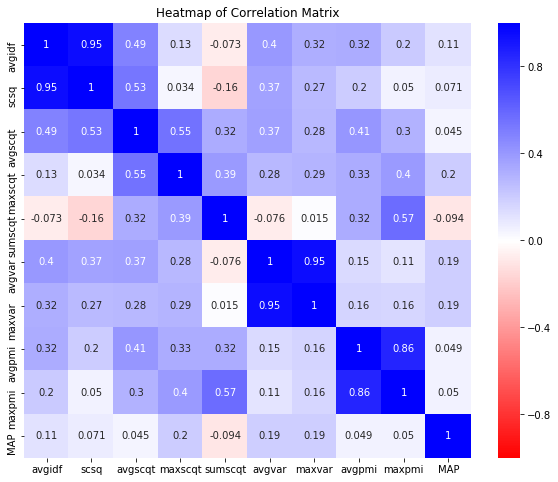

In [18]:
# Plotting correlation matrix 
import matplotlib.pyplot as plt
import seaborn as sns
corr = df3[['avgidf','scsq','avgscqt','maxscqt','sumscqt','avgvar','maxvar','avgpmi','maxpmi','MAP']].corr()
print(corr)
plt.rc('figure', figsize=(10,8))
sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values, cmap='bwr_r', vmin=-1, vmax=1, annot=True)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [19]:
#Printing Correlation of Pre-retrieval metrices with MAP
print("Corr avgIDF and MAP : ", numpy.corrcoef(df2['avgidf'], dfmap['MAP'])[0, 1])
print("Corr SCS(Q) and MAP : ",numpy.corrcoef(df2['scsq'], dfmap['MAP'])[0, 1])
print("Corr MaxSCQ and MAP : ",numpy.corrcoef(df2['maxscqt'], dfmap['MAP'])[0, 1])
print("Corr maxVAR and MAP : ",numpy.corrcoef(df2['maxvar'], dfmap['MAP'])[0, 1])
print("Corr avgPMI and MAP : ",numpy.corrcoef(df2['avgpmi'], dfmap['MAP'])[0, 1])
print("Corr avgIDF and SCS(Q) : ",numpy.corrcoef(df2['avgidf'], df2['scsq'])[0, 1])

Corr avgIDF and MAP :  0.109436816157
Corr SCS(Q) and MAP :  0.0710765950405
Corr MaxSCQ and MAP :  0.197585334558
Corr maxVAR and MAP :  0.190088725948
Corr avgPMI and MAP :  0.0494407037784
Corr avgIDF and SCS(Q) :  0.949072364034


### References:
https://github.com/bonzanini/nlp-tutorial/blob/master/notebooks/01%20recipes_exploratory_analysis.ipynb

https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3

http://blog.christianperone.com/2011/10/machine-learning-text-feature-extraction-tf-idf-part-ii/

https://gist.github.com/amontalenti/7975313